# Final modelling notebooks

This is the final notebook with all the models explained. We will make 2 different approachs:
- Using only the features extracted on **final_notebook_feature_extraction**
- Using the features extracted + features extracted with TFIDF transformation

We will use 7 different types of machine learning models, on some of them we will apply GridSearch CV:
- Logistic regression as benchmark
- K-nearest Neighbors
- Support Vector Machine
- Decision Tree
- Random Forest
- XGBoost

And we are using the following metrics to evaluate the model:
- Classification accuracy
- Logarithmic loss
- Confusion matrix
- Recall or sensitivity
- Specifity
- Area under curve (AUC)
- F1 Score


# Index

- [1. Evaluation metrics explanined](#1.-Evaluation-metrics-explained)
- [2. Evaluation functions](#2.-Evaluation-functions)
- [3. First approach: Only features extracted](#3.-First-approach:-Only-features-extracted)
    - [Logistic regression as benchmark for first aproach](#3.1.-Logistic-regression)
    - [K-Nearest Neighbors](#3.2.-K-Nearest-Neighbors-Classifier-with-GridSearchCV)
    - [Support Vector Machine](#3.3.-Support-Vector-Machine-Classifier-with-GridSearchCV)
    - [Decision Tree](#3.4.-Decision-Tree-Classifier-with-GridSearchCV)
    - [Random Forest](#3.5.-Random-Forest-Classifier-with-GridSearchCV)
    - [XGBoost](#3.6.-Extreme-Gradient-Boosting-Classifier-with-GridSearchCV)
    - [Model comparison](#3.7.-Model-comparison)
- [4. Second approach: TFIDF Transformation + features](#4.-Second-approach:-TFIDF-Transformation-+-features)
    - [TFIDF Transformation](#TFIDF-Transformation)
    - [Passive aggressive classifier as benchmark for second aproach](#4.1.-Passive-Aggressive-Classifier-(Only-TFIDF-features))
    - [K-Nearest Neighbors](#4.2.-K-Nearest-Neighbors-Classifier-with-GridSearchCV)
    - [Support Vector Machine](#4.3.-Support-Vector-Machine-Classifier-with-GridSearchCV)
    - [Decision Tree](#4.4.-Decision-Tree-Classifier-with-GridSearchCV)
    - [Random Forest](#4.5.-Random-Forest-Classifier-with-GridSearchCV)
    - [XGBoost](#4.6.-Extreme-Gradient-Boosting-Classifier-with-GridSearchCV)
    - [Model comparison](#4.7.-Model-comparison)
- [5. Choose the best model](#5.-Choose-the-best-model)
- [6. Pickle the best model](#6.-Save-as-pickle)

# 1. Evaluation metrics explained

## Classification accuracy

Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions (True Positives + True Negatives) to the total number of input samples:

&nbsp;&nbsp; $$Accuracy = \frac{True Positives + True Negatives}{TotalExamples}$$ &nbsp;&nbsp;

## Logarithmic loss
Logarithmic Loss or Log Loss, works by penalising the false classifications. It works well for multi-class classification. When working with Log Loss, the classifier must assign probability to each class for all the samples. Suppose, there are N samples belonging to M classes, then the Log Loss is calculated as below :

&nbsp;&nbsp; $$Logarithmic Loss = \frac{-1}{N}\sum\limits_{i=1}^{N}\sum\limits_{j=1}^{M} y_{i_j} \times log(p_{i_j})$$ &nbsp;&nbsp;

## Confusion Matrix
A confusion matrix is a matrix representation of the prediction results of any binary testing that is often used to describe the performance of the classification model (or “classifier”) on a set of test data for which the true values are known.

&nbsp;&nbsp; ![ConfusionMatrix](../imgs/ConfusionMatrix.png)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

Important terms:

- True Positives : The cases in which we predicted YES and the actual output was also YES.
- True Negatives : The cases in which we predicted NO and the actual output was NO.
- False Positives : The cases in which we predicted YES and the actual output was NO.
- False Negatives : The cases in which we predicted NO and the actual output was YES.

## Recall or Sensitivity
Recall or Sensitivity gives us the True Positive Rate (TPR), which is defined as TP / (FN+TP). True Positive Rate corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points.

![ConfusionMatrixSensitivity](../imgs/ConfusionMatrixSensitivity.png)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

$$True Positive Rate = \frac{True Positive}{False Negative + True Positive}$$ &nbsp;&nbsp;
                                                                       
## Specifity
Specifity gives us the True Negative Rate (TNR), which is defined as TN / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are correctly considered as negative, with respect to all negative data points.

![ConfusionMatrixSpecifity](../imgs/ConfusionMatrixSpecifity.png)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

&nbsp;&nbsp; $$True Negative Rate = \frac{True Negative}{True Negative Negative + False Positive}$$ &nbsp;&nbsp;


## Area under curve (AUC)
Area Under Curve(AUC) is one of the most widely used metrics for evaluation. It is used for binary classification problem. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example.

## Precision
Precision is the number of correct positive results divided by the number of positive results predicted by the classifier.

&nbsp;&nbsp; $$Precision = \frac{True Positives}{True Positives + False Positives}$$ &nbsp;&nbsp;


## F1 Score
F1 Score is used to measure a test's accuracy. F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).

High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model. Mathematically, it can be expressed as :

&nbsp;&nbsp; $$F1 = 2 \times \frac{1}{\frac{1}{precision} + \frac{1}{recall}}$$ &nbsp;&nbsp;

F1 Score tries to find the balance between precision and recall.

# 2. Evaluation functions

## ROC AUC curve

To plot ROC AUC curve we are going to use <code>prediction_results(model, y_test, X_test, y_pred, probs)</code> function.

Also it returns as **outputs**:
- Accuracy score
- AUC score
- F1 score

In [1]:
def prediction_results(model, y_test, X_test, y_pred, probs):
    
    # testing AUC
    auc = roc_auc_score(y_test, probs)
    print('Testing AUC score: %.2f' % auc)

    # accuracy score, log loss and F1 Score
    accuracy = (model.score(X_test, y_test) * 100)
    f1 = f1_score(y_test, y_pred)
    print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
    print('Accuracy: %.2f' % accuracy)
    print('F1 Score: %.2f' % f1)

    # roc curve calculation
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

    # plot the roc curve
    plt.plot(false_positive_rate, true_positive_rate, marker = ',')
    
    # no skill limits
    plt.plot([0, 1], [0, 1], linestyle = '--')
    
    plt.title('Receiver Operating Characteristic Curve \n', fontsize = 16)
    plt.xlabel('\n False Positive Rate (FPR)', fontsize = 13)
    plt.ylabel('Sensitivity/ Recall (TTR) \n', fontsize = 13)
    plt.legend(["AUC = %.2f"%auc])
    plt.show();
    
    return accuracy, auc, f1

## Confusion matrix
To plot the Confusion Matrix we are going to use <code>plot_confusion_matrix(y_test, y_pred)</code> function:

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots(figsize = (7, 5.5))
    sns.heatmap(cf_matrix, annot = labels, ax = ax, fmt = '',cmap = 'Blues', annot_kws = {"size": 13})

    # Labels, title and ticks
    label_font = {'size':'15'}  
    ax.set_xlabel(' \n Predicted values', fontdict = label_font);
    ax.set_ylabel('Actual values \n', fontdict = label_font);

    title_font = {'size':'16'}  # 
    ax.set_title('Confusion Matrix \n', fontdict = title_font);

    ax.tick_params(axis = 'both', which = 'major', labelsize = 13) 
    ax.xaxis.set_ticklabels(['Fake', 'Real']);
    ax.yaxis.set_ticklabels(['Fake', 'Real']);
    plt.show()

# 3. First approach: Only features extracted

In [3]:
import pandas as pd
pd.options.display.max_columns = None

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
df.head()

,topic,text,headline,words_h,word_size_h,avg_syllables_word_h,unique_words_h,ttr_h,mltd_h,sents,words,avg_words_sent,avg_word_size,avg_syllables_word,unique_words,ttr,mltd,huerta_score,szigriszt_score,upper_case_ratio,entity_ratio,quotes,quotes_ratio,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,Science,la nasa recupera el contacto con un satélite d...,la nasa recupera el contacto con un satélite d...,16,5.38,2.50,87.50,93.75,71.68,16,479,29.94,4.76,2.04,31.52,43.22,56.66,53.90,49.96,3.87,2.71,0,0.00,4.80,24.43,17.75,15.66,7.10,1.67,8.35,3.13,0.00,1
1,Economy,amlo aceleraría el consumo y el crecimiento ec...,amlo aceleraría el consumo y el crecimiento ec...,11,5.27,2.55,81.82,90.91,33.88,5,206,41.20,4.58,1.89,33.98,49.03,57.83,51.42,47.69,4.35,5.83,2,0.97,9.22,22.82,15.53,16.50,11.17,0.49,6.31,0.97,0.00,1
2,Sport,al borde de un colapso nervioso quedó el hábil...,compañero de james se ‘calvea’ y le juega pesa...,12,3.75,1.67,100.00,100.00,0.00,13,368,28.31,4.23,1.70,41.58,53.26,64.43,75.96,72.72,2.60,3.80,7,1.90,7.34,16.58,15.22,13.32,13.04,4.35,8.15,3.53,0.54,0
3,Politics,"mediante pupitrazo de último minuto anoche, el...",dian gravará este año a los niños que recojan ...,12,4.58,1.92,100.00,100.00,0.00,8,269,33.62,4.75,1.92,40.15,53.53,65.16,57.35,53.71,2.02,1.49,4,1.49,2.23,22.30,19.33,15.24,10.04,0.74,6.69,3.35,0.00,0
4,Politics,muy temprano esta mañana el expresidente y aho...,uribe asegura que insultó 358 guerrilleros,6,6.17,2.50,100.00,100.00,0.00,9,260,28.89,4.18,1.59,49.62,61.54,93.74,81.97,78.75,1.81,2.69,7,2.69,5.77,17.31,8.46,10.77,20.00,5.38,10.38,5.00,0.77,0


In [4]:
df.shape

(3974, 33)

In [5]:
df.columns

Index(['topic', 'text', 'headline', 'words_h', 'word_size_h',
       'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
       'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word',
       'unique_words', 'ttr', 'mltd', 'huerta_score', 'szigriszt_score',
       'upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

In [6]:
numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

## 3.1. Logistic regression

Testing AUC score: 0.96
Logloss: 3.27
Accuracy: 90.53
F1 Score: 0.91


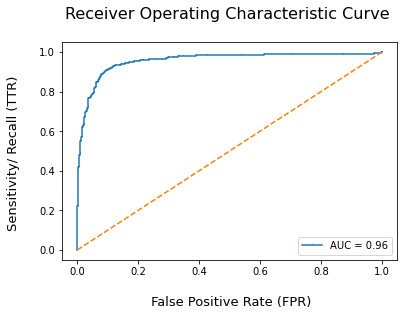

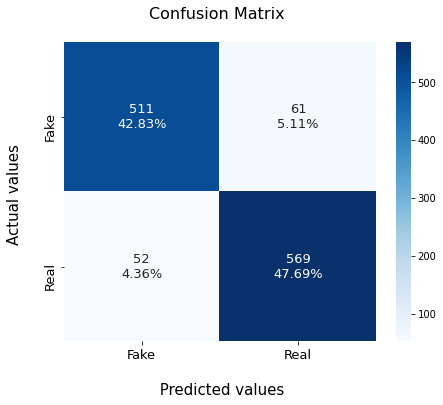

CPU times: user 8.02 s, sys: 7.98 s, total: 16 s
Wall time: 2.98 s


<AxesSubplot:title={'center':'Logistic Regressor Feature Importance'}>

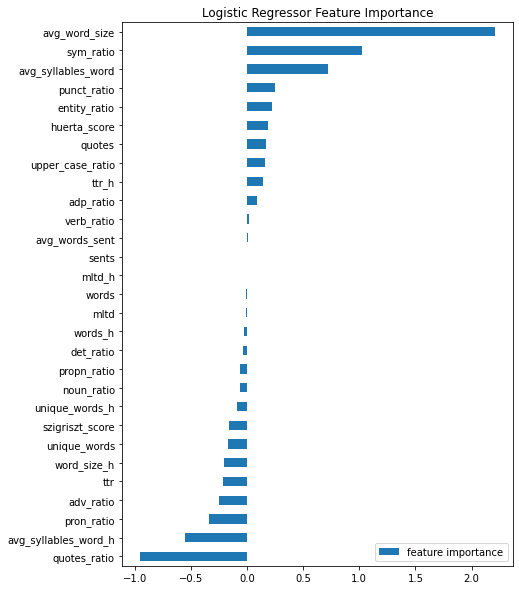

In [18]:
%%time

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, f1_score, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Training and testing split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = df[numeric_features]
feature_names = df[numeric_features].columns.tolist()

# Training test split and removing outliers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

idx = np.all(stats.zscore(X_train) < 3.5, axis = 1) # index of the rows without outliers

X_train = X_train.loc[idx]
y_train = y_train.loc[idx]


########### Logistic Regression Classifier ########### 

logreg_model = LogisticRegression(max_iter = 2000)
logreg_model.fit(X_train, y_train)


########### Predictions and results ###########

# prediction and results
y_pred = logreg_model.predict(X_test)
probs = logreg_model.predict_proba(X_test)
probs = probs[:, 1]

logreg_accuracy_score, logreg_auc_score, logreg_f1_score = prediction_results(logreg_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

importance = logreg_model.coef_[0]

df_feature_importance = pd.DataFrame(logreg_model.coef_[0], index = feature_names, columns = ['feature importance']).sort_values('feature importance', ascending = True)

# plot feature importance

fig, ax = plt.subplots(figsize = [7, 10])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Logistic Regressor Feature Importance');

## 3.2. K-Nearest Neighbors Classifier with GridSearchCV

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    3.9s finished


Best hyperparameters: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
Testing AUC score: 0.95
Logloss: 4.08
Accuracy: 88.18
F1 Score: 0.88


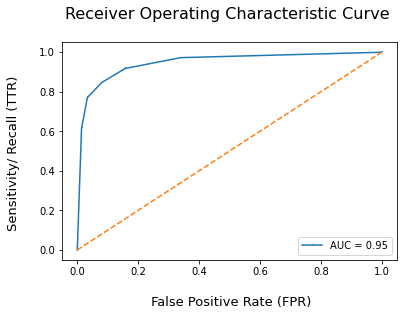

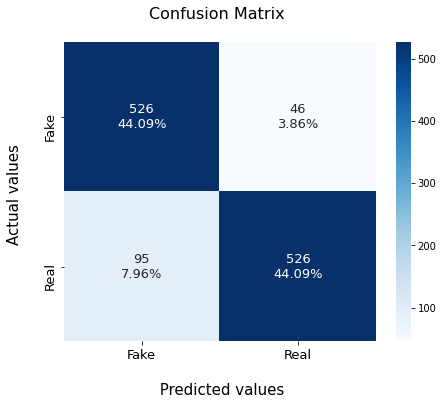

CPU times: user 49.4 s, sys: 156 ms, total: 49.6 s
Wall time: 52.6 s


<AxesSubplot:title={'center':'K-Nearest Neighbors Classifier Feature Importance'}>

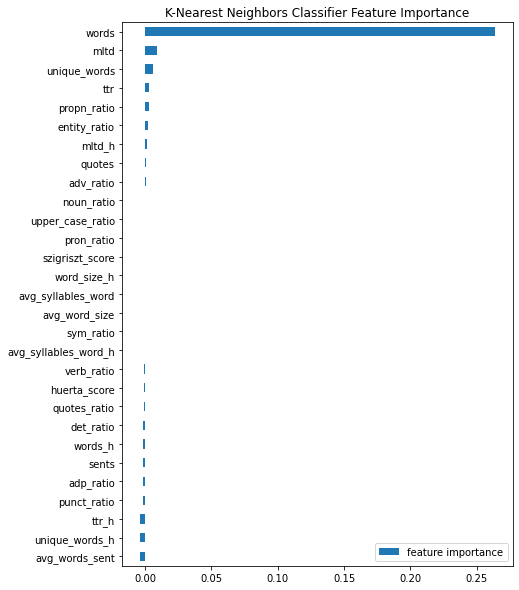

In [19]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss
from sklearn.inspection import permutation_importance

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = df[numeric_features]
feature_names = df[numeric_features].columns.tolist()

# Training test split and removing outliers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

idx = np.all(stats.zscore(X_train) < 3.5, axis = 1)

X_train = X_train.loc[idx]
y_train = y_train.loc[idx]

########### K-Nearest Neighbors Classifier ###########

# hyperparameters for the grid search

param_grid = {
    'leaf_size': list(range(1, 5)),
    'n_neighbors': list(range(1, 10)),
    'p': [1, 2]
}

# classifier
knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model, param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
knn_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = knn_model.predict(X_test)
probs = knn_model.predict_proba(X_test)
probs = probs[:, 1]

knn_accuracy_score, knn_auc_score, knn_f1_score = prediction_results(knn_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

results = permutation_importance(knn_model, X_train, y_train, scoring = 'accuracy')
importance = results.importances_mean

df_feature_importance = pd.DataFrame(importance, index = feature_names, 
                                     columns = ['feature importance']).sort_values('feature importance')

fig, ax = plt.subplots(figsize = [7, 10])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'K-Nearest Neighbors Classifier Feature Importance');

## 3.3. Support Vector Machine Classifier with GridSearchCV

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Best hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Testing AUC score: 0.94
Logloss: 4.26
Accuracy: 87.68
F1 Score: 0.88


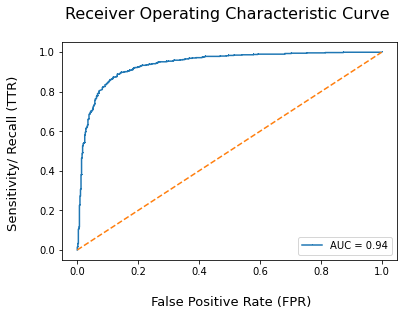

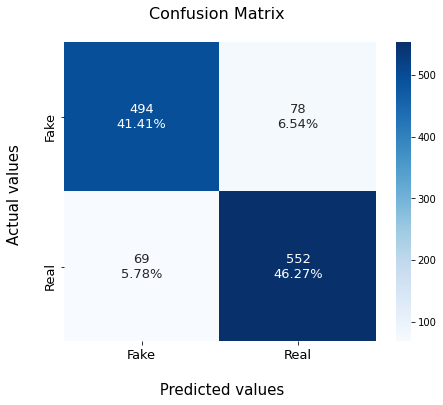

CPU times: user 2.8 s, sys: 234 ms, total: 3.03 s
Wall time: 11 s


In [20]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Numeric features & train, test split ########### 
numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = df[numeric_features]
feature_names = df[numeric_features].columns.tolist()

# Training test split and removing outliers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

idx = np.all(stats.zscore(X_train) < 3.5, axis = 1)

X_train = X_train.loc[idx]
y_train = y_train.loc[idx]

########### SVM Classifier ###########

# hyperparameters for the grid search

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01],
    'kernel': ['rbf']
}

# classifier
svc_model = SVC(probability = True)

grid_search = GridSearchCV(svc_model, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
svc_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = svc_model.predict(X_test)
probs = svc_model.predict_proba(X_test)
probs = probs[:, 1]

svc_accuracy_score, svc_auc_score, svc_f1_score = prediction_results(svc_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 3.4. Decision Tree Classifier with GridSearchCV

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 174 out of 189 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.0s finished


Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 4}
Testing AUC score: 0.90
Logloss: 4.20
Accuracy: 87.85
F1 Score: 0.88


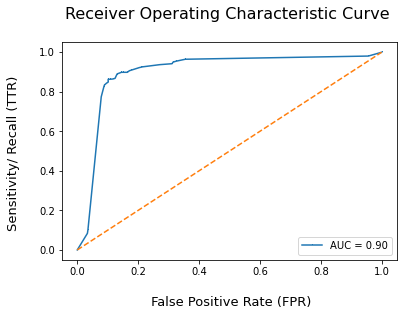

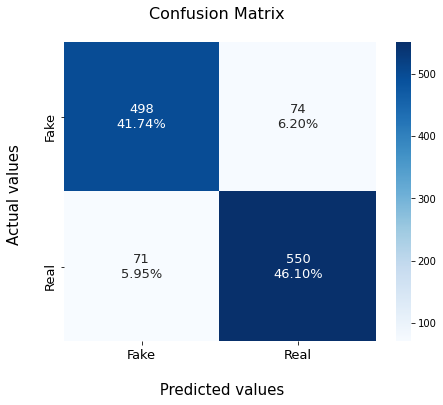

CPU times: user 1.14 s, sys: 219 ms, total: 1.36 s
Wall time: 1.65 s


<AxesSubplot:title={'center':'Decision Tree Classifier Feature Importance'}>

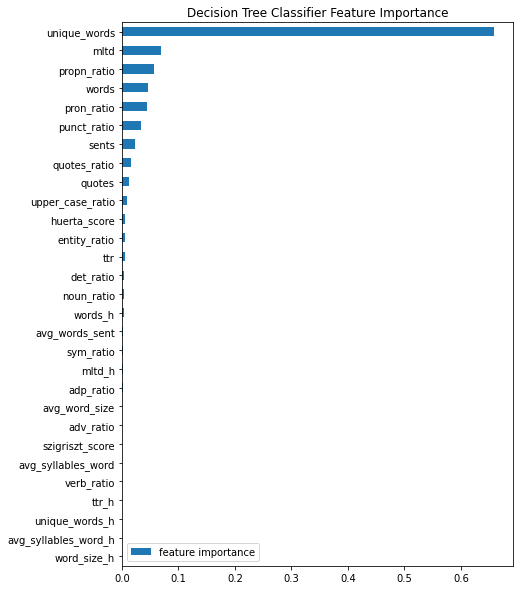

In [21]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = df[numeric_features]
tfvocab = df[numeric_features].columns.tolist()

# Training test split and removing outliers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

idx = np.all(stats.zscore(X_train) < 3.5, axis = 1)

X_train = X_train.loc[idx]
y_train = y_train.loc[idx]

########### Decision Tree Classifier ###########

# hyperparameters for the grid search

param_grid = {
    'max_depth': list(range(1, 10)),
    'min_samples_leaf': list(range(1, 8)),
}

# classifier
dt_model = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_model, param_grid, scoring = 'accuracy', cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
dt_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = dt_model.predict(X_test)
probs = dt_model.predict_proba(X_test)
probs = probs[:, 1]

dt_accuracy_score, dt_auc_score, dt_f1_score = prediction_results(dt_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

########### Feature importance ###########

df_feature_importance = pd.DataFrame(dt_model.feature_importances_, index = tfvocab, 
                                     columns = ['feature importance']).sort_values('feature importance')

fig, ax = plt.subplots(figsize = [7, 10])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Decision Tree Classifier Feature Importance');

## 3.5. Random Forest Classifier with GridSearchCV

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.1min finished


Best hyperparameters: {'bootstrap': True, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
Testing AUC score: 0.97
Logloss: 2.95
Accuracy: 91.45
F1 Score: 0.92


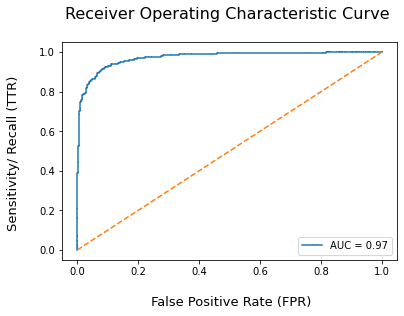

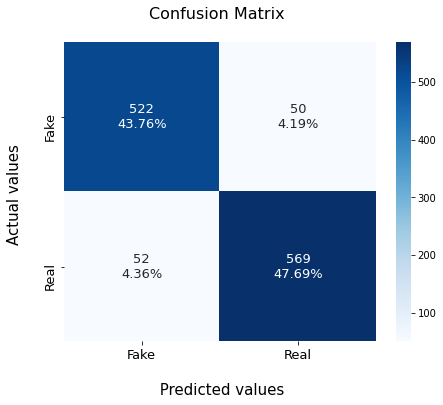

CPU times: user 5.19 s, sys: 266 ms, total: 5.45 s
Wall time: 1min 8s


<AxesSubplot:title={'center':'Random Forest Classifier Feature Importance'}>

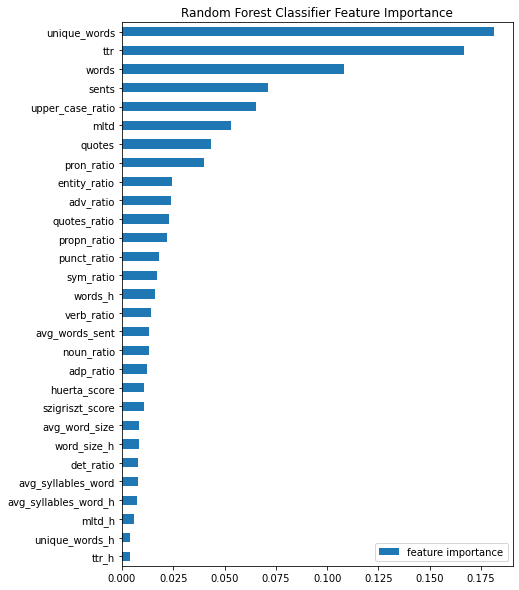

In [22]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = df[numeric_features]
feature_names = df[numeric_features].columns.tolist()

# Training test split and removing outliers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

idx = np.all(stats.zscore(X_train) < 3.5, axis = 1)

X_train = X_train.loc[idx]
y_train = y_train.loc[idx]


########### Random Forest CLassifier ########### 

# hyperparameters for the grid search

param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [5, 10],
    'n_estimators': [400, 600]
}

# classifier

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
rf_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = rf_model.predict(X_test)
probs = rf_model.predict_proba(X_test)
probs = probs[:, 1]

rf_accuracy_score, rf_auc_score, rf_f1_score = prediction_results(rf_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

df_feature_importance = pd.DataFrame(rf_model.feature_importances_, index = feature_names, 
                                     columns = ['feature importance']).sort_values('feature importance')

fig, ax = plt.subplots(figsize = [7, 10])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Random Forest Classifier Feature Importance');

## 3.6. Extreme Gradient Boosting Classifier with GridSearchCV

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.0min finished


Best hyperparameters: {'alpha': 0.1, 'colsample_bytree': 0.5, 'lambda': 0, 'learning_rate': 0.015, 'max_depth': 12, 'min_child_weight': 0.2, 'n_estimators': 1200, 'subsample': 0.3}
Testing AUC score: 0.98
Logloss: 2.75
Accuracy: 92.04
F1 Score: 0.92


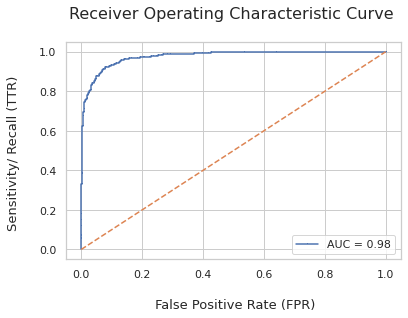

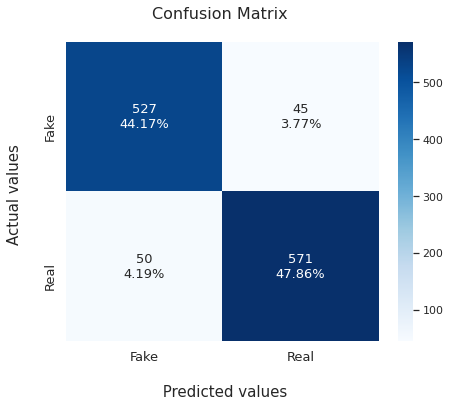

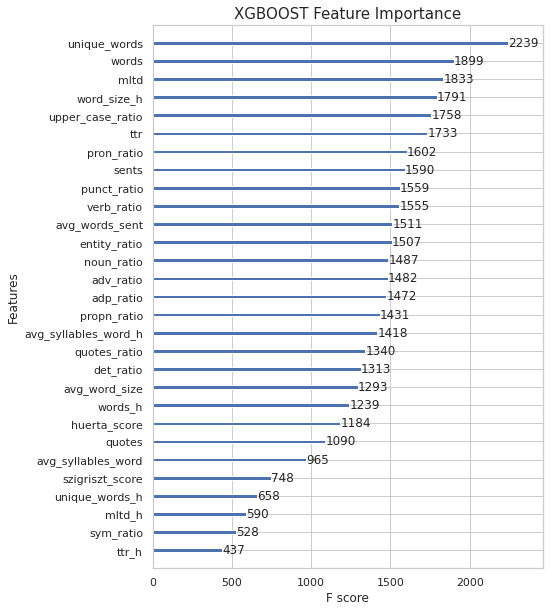

CPU times: user 8.45 s, sys: 1.44 s, total: 9.89 s
Wall time: 2min 10s


In [35]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Training and testing split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = df[numeric_features]
feature_names = df[numeric_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training test split and removing outliers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

idx = np.all(stats.zscore(X_train) < 3.5, axis = 1)

X_train = X_train.loc[idx]
y_train = y_train.loc[idx]


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.005, 0.01, 0.015],
              'n_estimators': [1200],
              'max_depth': [11, 12], 
              'subsample': [0.3, 0.4], 
              'colsample_bytree': [0.5, 0.75],
              'min_child_weight' : [0.2],
              'lambda': [0],
              'alpha': [0.1, 0.2]}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 43)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, 
                                   scoring = 'roc_auc', n_jobs = -1, cv = skf.split(X_train, y_train), verbose = 2)

grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
xgb_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

xgb_accuracy_score, xgb_auc_score, xgb_f1_score = prediction_results(xgb_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

# feature importance with default names

f, ax = plt.subplots(figsize = [7, 10])
axsub = xgb.plot_importance(xgb_model, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]

# feature importance
plt.title("XGBOOST Feature Importance", fontsize = 15)
axsub.set_yticklabels(list_yticklabels)
plt.show()

<Figure size 4800x3200 with 0 Axes>

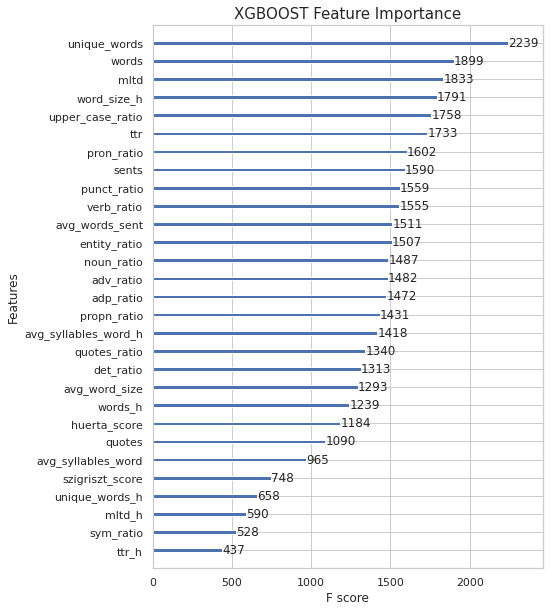

In [37]:
# feature importance with default names
plt.figure(dpi=800)
f, ax = plt.subplots(figsize = [7, 10])
axsub = xgb.plot_importance(xgb_model, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]

# feature importance
plt.title("XGBOOST Feature Importance", fontsize = 15)
axsub.set_yticklabels(list_yticklabels)
plt.savefig('../imgs/feature_importance_xgboost1.png', bbox_inches = 'tight', dpi = 800)

## 3.7. Model comparison

We are going to plot all models with the proposed metrics: **Accuracy**, **AUC testing score**, **F1 score**:

In [23]:
accuracy_score = [logreg_accuracy_score, knn_accuracy_score, svc_accuracy_score, dt_accuracy_score, rf_accuracy_score, xgb_accuracy_score]
auc_score = [logreg_auc_score, knn_auc_score, svc_auc_score, dt_auc_score, rf_auc_score, xgb_auc_score]
f1_score = [logreg_f1_score, knn_f1_score, svc_f1_score, dt_f1_score, rf_f1_score, xgb_f1_score]
models = ['LREG', 'KNN', 'SVC', 'DT', 'RF', 'XGBOOST']

data = pd.DataFrame({'Models': models, 'Accuracy score': accuracy_score, 'AUC score': auc_score, 'F1 score': f1_score})

<Figure size 4800x3200 with 0 Axes>

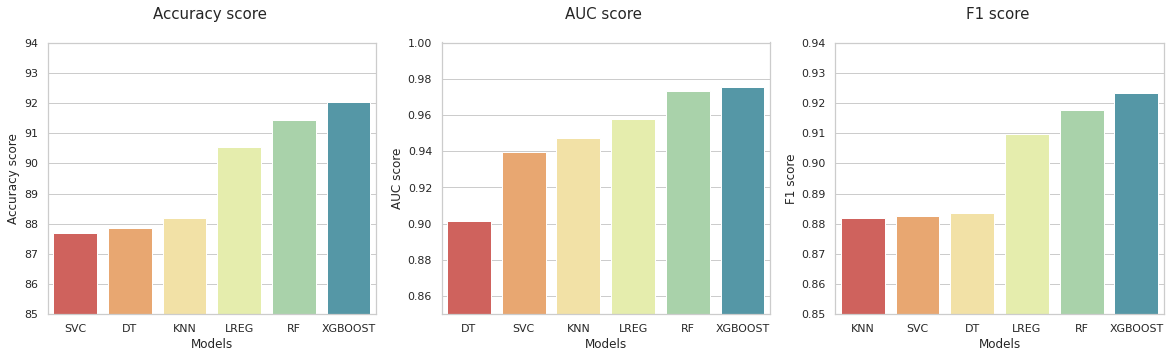

In [27]:
plt.figure(dpi=800)
f, axs = plt.subplots(1,3, figsize = (20, 5))
sns.set(style = 'whitegrid')

ax1 = sns.barplot(y = 'Accuracy score', x = 'Models', data = data, order = data.sort_values('Accuracy score').Models,
            ax = axs[0], palette = 'Spectral')
ax1ylim = ax1.set_ylim([85, 94])
ax1title = ax1.set_title('Accuracy score \n', fontsize = 15)


ax2 = sns.barplot(y = 'AUC score', x = 'Models', data = data, order = data.sort_values('AUC score').Models,
            ax = axs[1], palette = 'Spectral')
ax2ylim = ax2.set_ylim([0.85, 1.0])
ax2title = ax2.set_title('AUC score \n', fontsize = 15)


ax3 = sns.barplot(y = 'F1 score', x = 'Models', data = data, order = data.sort_values('F1 score').Models,
            ax = axs[2], palette = 'Spectral')
ax3ylim = ax3.set_ylim([0.85, 0.94])
ax3title = ax3.set_title('F1 score \n', fontsize = 15)

plt.savefig('../imgs/eval_metrics_models1.png', bbox_inches = 'tight', dpi=800)

In [26]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

print('------ Without TFIDF Features ------')

print('\n Decision Tree \n', classification_report(y_test, y_pred_dt))
print('\n Random Forest \n', classification_report(y_test, y_pred_rf))
print('\n XGBOOST without TFIDF Features \n', classification_report(y_test, y_pred_xgb))

------ Without TFIDF Features ------

 Decision Tree 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       572
           1       0.88      0.89      0.88       621

    accuracy                           0.88      1193
   macro avg       0.88      0.88      0.88      1193
weighted avg       0.88      0.88      0.88      1193


 Random Forest 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       572
           1       0.92      0.92      0.92       621

    accuracy                           0.92      1193
   macro avg       0.92      0.92      0.92      1193
weighted avg       0.92      0.92      0.92      1193


 XGBOOST without TFIDF Features 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       572
           1       0.93      0.92      0.92       621

    accuracy                           0.92      1193
   macro avg       0

# 4. Second approach: TFIDF Transformation + features

## TFIDF Transformation

In [16]:
#removing outliers on whole corpus

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')

numeric_labels = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 
                  'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                  'huerta_score', 'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes_ratio', 'propn_ratio', 
                  'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 
                  'sym_ratio', 'label']
print(df.shape)

idx = np.all(stats.zscore(df[numeric_labels]) < 3.5, axis = 1)
df2 = df.loc[idx]

print(df2.shape)
df2.to_csv('../data/spanish_corpus_features_v6_no_outliers.csv', encoding = 'utf-8', index = False)

(3974, 33)
(3725, 33)


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')

####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡', '‘', '’', '“', '”'])  
non_words.extend(map(str, range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = spanish_stopwords)

# text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

# feature names
# tfvocab = tfidf_vectorizer.get_feature_names()

## 4.1. Logistic Regression Classifier

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/pipe11/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):


Testing AUC score: 0.96
Logloss: 3.15
Accuracy: 90.88
F1 Score: 0.91


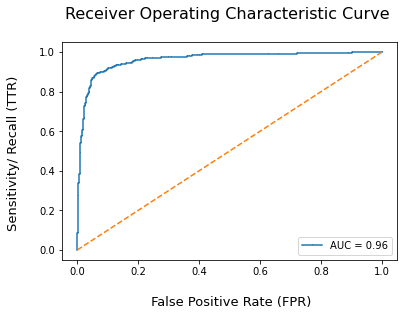

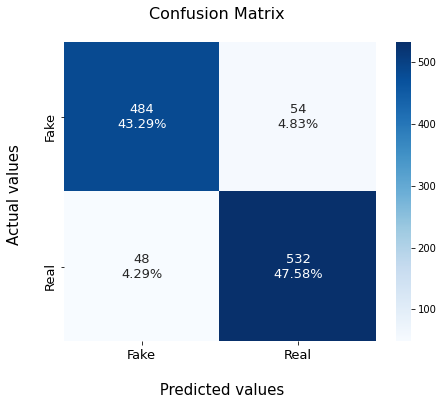

CPU times: user 3min 17s, sys: 3min 50s, total: 7min 8s
Wall time: 1min 41s


In [17]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score
import pickle

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

tfidf_vectorizer = pickle.load(open('../predictors/tfidf_vectorizer.pkl', 'rb'))
text_vectorized = tfidf_vectorizer.transform(df['text'])
tfvocab = tfidf_vectorizer.get_feature_names()

########### Training and testing split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']


X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
feature_names = df[numeric_features].columns.tolist() + tfvocab

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


########### Logistic Regression Classifier ########### 

logreg_model2 = LogisticRegression(max_iter = 5000)
logreg_model2.fit(X_train, y_train)


########### Predictions and results ###########

# prediction and results
y_pred = logreg_model2.predict(X_test)
probs = logreg_model2.predict_proba(X_test)
probs = probs[:, 1]

logreg2_accuracy_score, logreg2_auc_score, logreg2_f1_score = prediction_results(logreg_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 4.2. K-Nearest Neighbors Classifier with GridSearchCV

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.5min finished


Best hyperparameters: {'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
Testing AUC score: 0.95
Logloss: 4.02
Accuracy: 88.37
F1 Score: 0.88


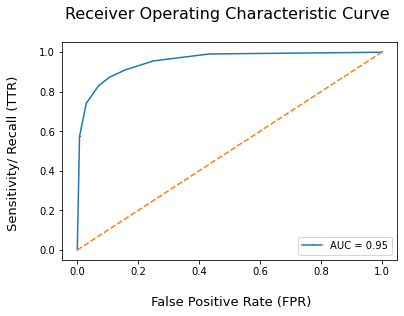

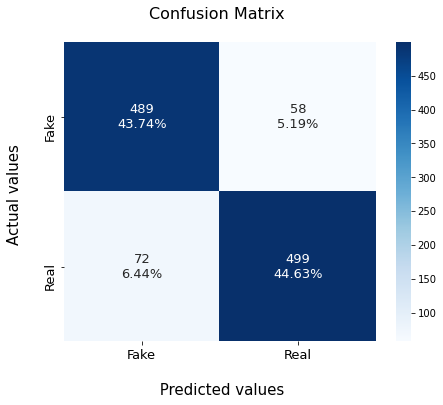

CPU times: user 1min 30s, sys: 734 ms, total: 1min 31s
Wall time: 2min 25s


In [16]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score
import pickle

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

tfidf_vectorizer = pickle.load(open('../predictors/tfidf_vectorizer.pkl', 'rb'))
text_vectorized = tfidf_vectorizer.transform(df['text'])

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
feature_names = df[numeric_features].columns.tolist() + tfvocab
tfvocab = tfidf_vectorizer.get_feature_names()

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

########### K-Nearest Neighbors Classifier ###########

# hyperparameters for the grid search

param_grid = {
    'leaf_size': list(range(1, 5)),
    'n_neighbors': list(range(1, 10)),
    'p': [1, 2]
}

# classifier
knn_model2 = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model2, param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
knn_model2 = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = knn_model2.predict(X_test)
probs = knn_model2.predict_proba(X_test)
probs = probs[:, 1]

knn2_accuracy_score, knn2_auc_score, knn2_f1_score = prediction_results(knn_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 4.3. Support Vector Machine Classifier with GridSearchCV

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


Best hyperparameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Testing AUC score: 0.95
Logloss: 4.20
Accuracy: 87.84
F1 Score: 0.88


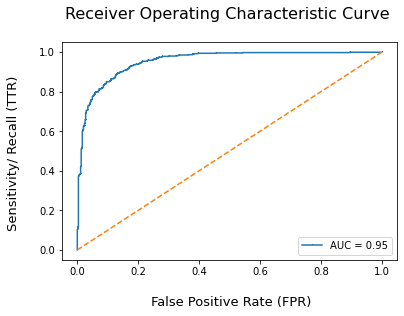

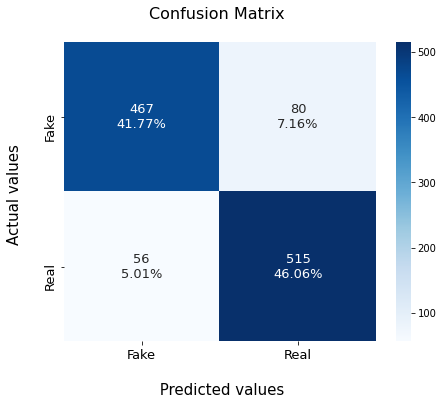

CPU times: user 1min 42s, sys: 312 ms, total: 1min 42s
Wall time: 5min 2s


In [15]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score
import pickle

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

tfidf_vectorizer = pickle.load(open('../predictors/tfidf_vectorizer.pkl', 'rb'))
text_vectorized = tfidf_vectorizer.transform(df['text'])

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])

# training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

########### Decision Tree Classifier ###########

# hyperparameters for the grid search

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01],
    'kernel': ['rbf']
}

# classifier
svc_model2 = SVC(probability = True)

grid_search = GridSearchCV(svc_model2, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
svc_model2 = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = svc_model2.predict(X_test)
probs = svc_model2.predict_proba(X_test)
probs = probs[:, 1]

svc2_accuracy_score, svc2_auc_score, svc2_f1_score = prediction_results(svc_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 4.4. Decision Tree Classifier with GridSearchCV

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 441 candidates, totalling 1323 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1308 out of 1323 | elapsed:   43.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 1323 out of 1323 | elapsed:   43.9s finished


Best hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 5}
Testing AUC score: 0.96
Logloss: 3.49
Accuracy: 89.89
F1 Score: 0.90


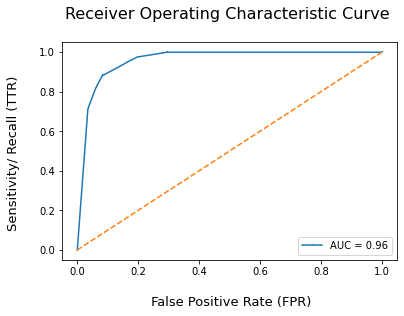

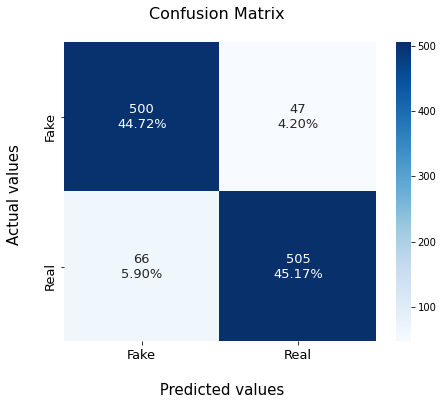

CPU times: user 54.8 s, sys: 1.69 s, total: 56.5 s
Wall time: 1min 35s


In [14]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score
import pickle

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

tfidf_vectorizer = pickle.load(open('../predictors/tfidf_vectorizer.pkl', 'rb'))
text_vectorized = tfidf_vectorizer.transform(df['text'])
tfvocab = tfidf_vectorizer.get_feature_names()

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
feature_names = df[numeric_features].columns.tolist() + tfvocab

# training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

########### Decision Tree Classifier ###########

# hyperparameters for the grid search

param_grid = {
    'max_depth': list(range(1, 8)),
    'min_samples_leaf': list(range(1, 10)),
    'criterion': ['gini'],
    'min_samples_split': list(range(1, 8))
}

# classifier
dt_model2 = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_model2, param_grid, scoring = 'accuracy', cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
dt_model2 = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = dt_model2.predict(X_test)
probs = dt_model2.predict_proba(X_test)
probs = probs[:, 1]

dt2_accuracy_score, dt2_auc_score, dt2_f1_score = prediction_results(dt_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 4.5. Random Forest Classifier with GridSearchCV

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.1min finished


{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 600}
Testing AUC score: 0.99
Logloss: 1.95
Accuracy: 94.36
F1 Score: 0.94


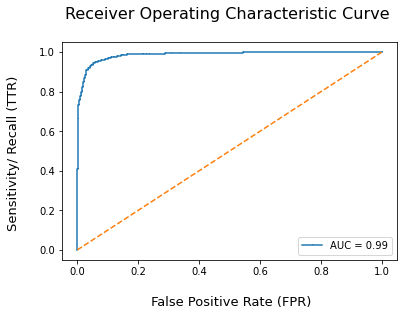

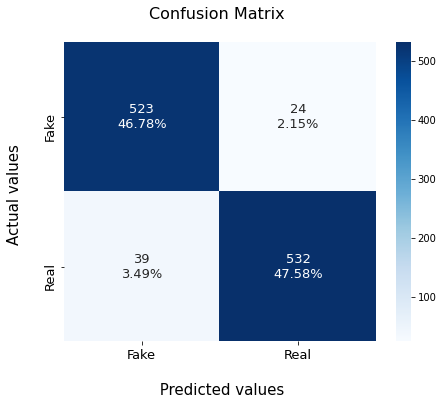

CPU times: user 1min 6s, sys: 844 ms, total: 1min 7s
Wall time: 3min 13s


<AxesSubplot:title={'center':'Random Forest Classifier Feature Importance'}>

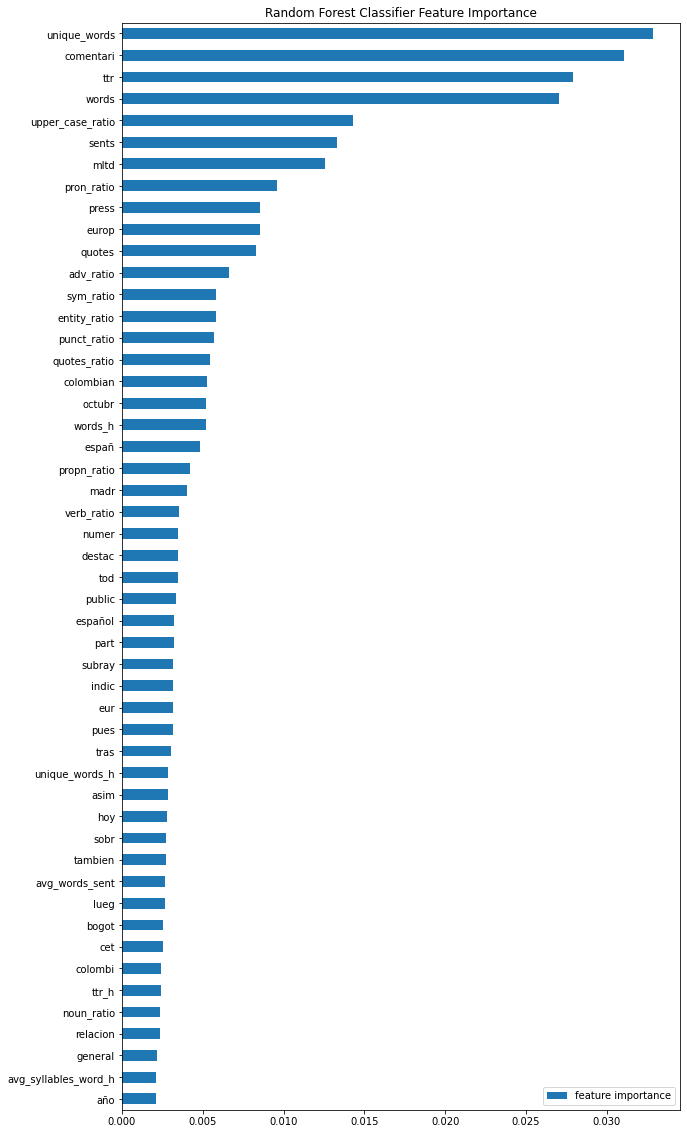

In [13]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score
import pickle

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

tfidf_vectorizer = pickle.load(open('../predictors/tfidf_vectorizer.pkl', 'rb'))
text_vectorized = tfidf_vectorizer.transform(df['text'])
tfvocab = tfidf_vectorizer.get_feature_names()

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
feature_names = df[numeric_features].columns.tolist() + tfvocab

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### Random Forest CLassifier ########### 

param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [10, 15],
    'n_estimators': [400, 600]
}

rf2 = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf2, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
rf_model2 = grid_search.best_estimator_


########### Predictions and results ###########

# predictions
y_pred = rf_model2.predict(X_test)
probs = rf_model2.predict_proba(X_test)
probs = probs[:, 1]

# prediction and results
y_pred = rf_model2.predict(X_test)
probs = rf_model2.predict_proba(X_test)
probs = probs[:, 1]

rf2_accuracy_score, rf2_auc_score, rf2_f1_score = prediction_results(rf_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

# feature importance with default names

df_feature_importance = pd.DataFrame(rf_model2.feature_importances_, index = feature_names, 
                                     columns = ['feature importance']).sort_values('feature importance', ascending = False)
df_feature_importance = df_feature_importance[0:50]
df_feature_importance = df_feature_importance.sort_values(by=['feature importance'])

fig, ax = plt.subplots(figsize = [10, 20])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Random Forest Classifier Feature Importance');

## 4.6. Extreme Gradient Boosting Classifier with GridSearchCV

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  1.1min remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.2min finished


Best hyperparameters: {'alpha': 0, 'colsample_bytree': 0.2, 'lambda': 0.5, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 0.5, 'n_estimators': 1200, 'subsample': 0.4}
Testing AUC score: 0.99
Logloss: 1.54
Accuracy: 95.53
F1 Score: 0.96


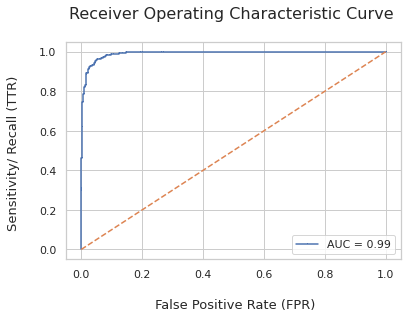

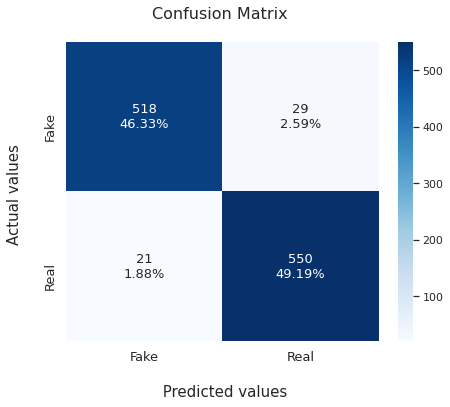

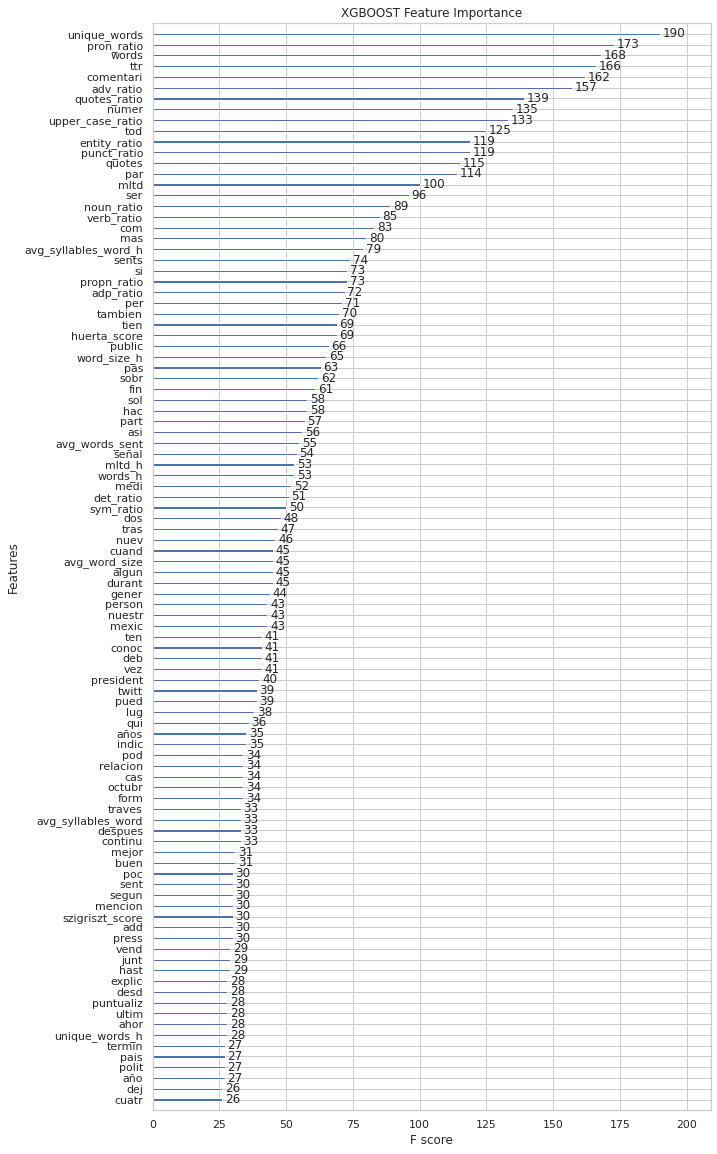

CPU times: user 1min 24s, sys: 1.47 s, total: 1min 25s
Wall time: 2min 35s


In [40]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score
import pickle

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

tfidf_vectorizer = pickle.load(open('../predictors/tfidf_vectorizer.pkl', 'rb'))
text_vectorized = tfidf_vectorizer.transform(df['text'])
tfvocab = tfidf_vectorizer.get_feature_names()

########### Numeric features & train, test split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
feature_names = df[numeric_features].columns.tolist() + tfvocab

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model2 = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.02],
              'n_estimators': [1000, 1200],
              'max_depth': [4, 6], 
              'subsample': [0.4], 
              'colsample_bytree': [0.1, 0.2],
              'min_child_weight' : [0.5],
              'lambda': [0.5],
              'alpha': [0]}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 43)
grid_search = GridSearchCV(estimator = xgb_model2, param_grid = xgb_params, 
                                   scoring = 'roc_auc', n_jobs = -1, cv = skf.split(X_train, y_train), verbose = 2)

grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
xgb_model2 = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = xgb_model2.predict(X_test)
probs = xgb_model2.predict_proba(X_test)
probs = probs[:, 1]

xgb2_accuracy_score, xgb2_auc_score, xgb2_f1_score = prediction_results(xgb_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 20])
axsub = xgb.plot_importance(xgb_model2, max_num_features = 100, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(feature_names))
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
list_yticklabels = [dict_features[int(i)] for i in list_yticklabels]

plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(list_yticklabels)
plt.show()

<Figure size 4800x3200 with 0 Axes>

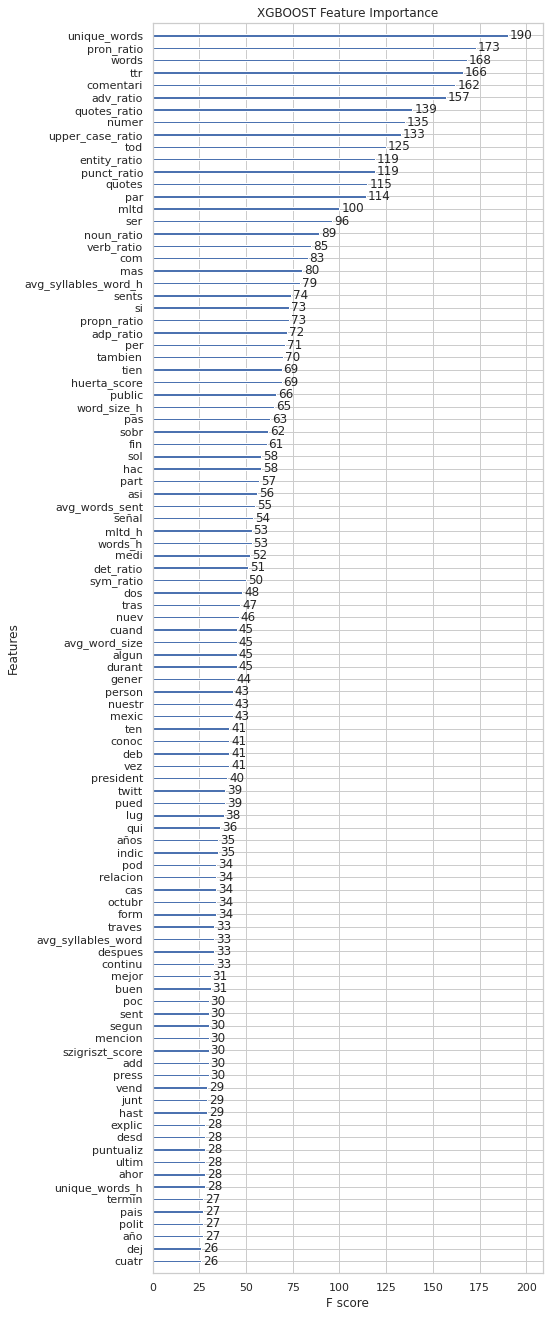

In [42]:
# feature importance with default names
plt.figure(dpi=800)
f, ax = plt.subplots(figsize = [7, 23])
axsub = xgb.plot_importance(xgb_model2, max_num_features = 100, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(feature_names))
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
list_yticklabels = [dict_features[int(i)] for i in list_yticklabels]

plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(list_yticklabels)
plt.savefig('../imgs/feature_importance_xgboost2.png', bbox_inches = 'tight', dpi = 800)

## 4.7. Model comparison

We are going to plot all models with the proposed metrics: **Accuracy**, **AUC testing score**, **F1 score**:

In [28]:
accuracy_score2 = [logreg2_accuracy_score, knn2_accuracy_score, svc2_accuracy_score, dt2_accuracy_score, rf2_accuracy_score, xgb2_accuracy_score]
auc_score2 = [logreg2_auc_score, knn2_auc_score, svc2_auc_score, dt2_auc_score, rf2_auc_score, xgb2_auc_score]
f1_score2 = [logreg2_f1_score, knn2_f1_score, svc2_f1_score, dt2_f1_score, rf2_f1_score, xgb2_f1_score]
models2 = ['LREG', 'KNN', 'SVC', 'DT', 'RF', 'XGBOOST']

data2 = pd.DataFrame({'Models': models2, 'Accuracy score': accuracy_score2, 'AUC score': auc_score2, 'F1 score': f1_score2})
data2

,Models,Accuracy score,AUC score,F1 score
0,LREG,90.876565,0.962607,0.912521
1,KNN,88.372093,0.954210,0.884752
2,SVC,87.835420,0.953843,0.883362
3,DT,89.892665,0.959038,0.899377
4,RF,94.364937,0.986908,0.944099
5,XGBOOST,95.527728,0.991653,0.956522


<Figure size 4800x3200 with 0 Axes>

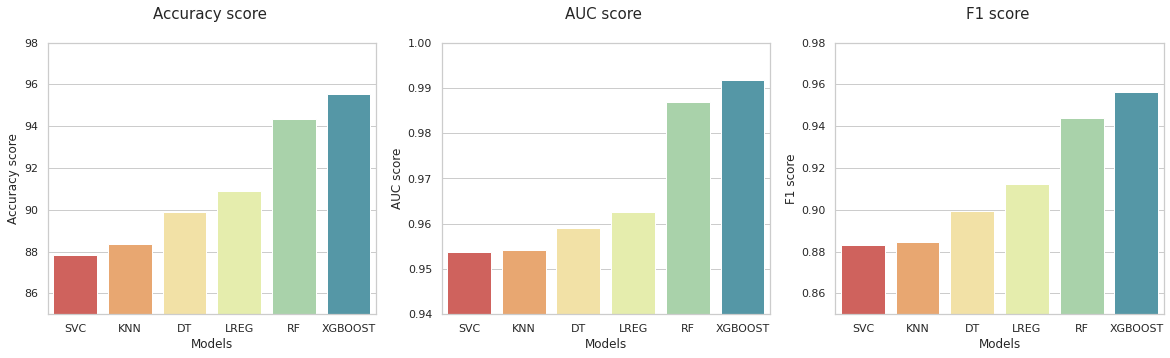

In [31]:
plt.figure(dpi = 800)
f, axs = plt.subplots(1,3, figsize = (20, 5))
sns.set(style = 'whitegrid')

ax1 = sns.barplot(y = 'Accuracy score', x = 'Models', data = data2, order = data2.sort_values('Accuracy score').Models,
            ax = axs[0], palette = 'Spectral')
ax1ylim = ax1.set_ylim([85, 98])
ax1title = ax1.set_title('Accuracy score \n', fontsize = 15)


ax2 = sns.barplot(y = 'AUC score', x = 'Models', data = data2, order = data2.sort_values('AUC score').Models,
            ax = axs[1], palette = 'Spectral')
ax2ylim = ax2.set_ylim([0.94, 1.0])
ax2title = ax2.set_title('AUC score \n', fontsize = 15)


ax3 = sns.barplot(y = 'F1 score', x = 'Models', data = data2, order = data2.sort_values('F1 score').Models,
            ax = axs[2], palette = 'Spectral')
ax3ylim = ax3.set_ylim([0.85, 0.98])
ax3title = ax3.set_title('F1 score \n', fontsize = 15)

plt.savefig('../imgs/eval_metrics_models2.png', bbox_inches = 'tight', dpi = 800)

In [51]:
print('------ TFIDF Features ------')

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']
X = hstack([csr_matrix(df[numeric_features]), text_vectorized[0:]])

# training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

y_pred_dt2 = dt_model2.predict(X_test)
y_pred_rf2 = rf_model2.predict(X_test)
y_pred_xgb2 = xgb_model2.predict(X_test)

print('\n Decision Tree \n', classification_report(y_test, y_pred_dt2))
print('\n Random Forest \n', classification_report(y_test, y_pred_rf2))
print('\n XGBOOST with TFDIF Features \n', classification_report(y_test, y_pred_xgb2))

------ TFIDF Features ------

 Decision Tree 
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       547
           1       0.91      0.88      0.90       571

    accuracy                           0.90      1118
   macro avg       0.90      0.90      0.90      1118
weighted avg       0.90      0.90      0.90      1118


 Random Forest 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       547
           1       0.96      0.94      0.95       571

    accuracy                           0.95      1118
   macro avg       0.95      0.95      0.95      1118
weighted avg       0.95      0.95      0.95      1118


 XGBOOST with TFDIF Features 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       547
           1       0.95      0.96      0.96       571

    accuracy                           0.96      1118
   macro avg       0.96      0.

# 5. Choose the best model

Independently of the classification and comparison results, all algorithms performed a good predictive power to classify fake and real news, and this demonstrates that the language independant features extracted and proposed in this project, complexity and lexical features, are very efficient to distingish between fake and real news:

In [33]:
data['TFIDF Vectorizer'] = ['no', 'no', 'no', 'no', 'no', 'no']
data2['TFIDF Vectorizer'] = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes']

data_final = pd.concat([data, data2])
data_final.reset_index(inplace = True, drop = True)

<Figure size 4800x3200 with 0 Axes>

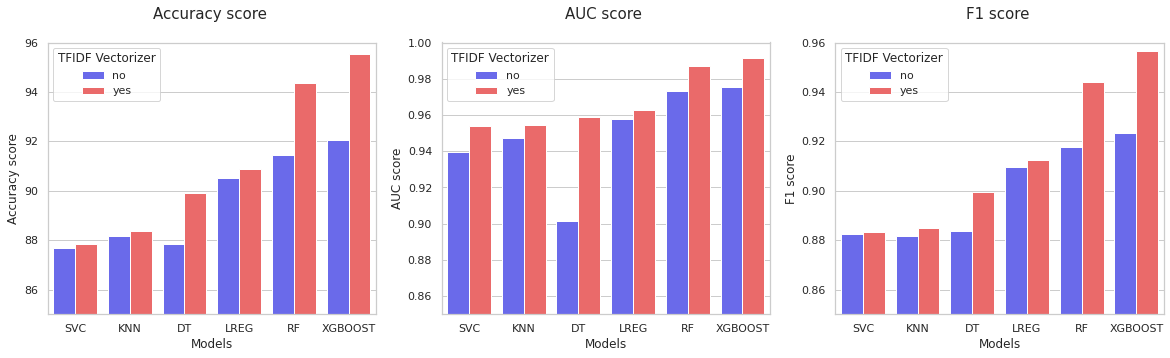

In [34]:
plt.figure(dpi = 800)
f, axs = plt.subplots(1,3, figsize = (20, 5))
sns.set(style = 'whitegrid')

ax1 = sns.barplot(y = 'Accuracy score', x = 'Models', data = data_final, hue = 'TFIDF Vectorizer',
                  order = data2.sort_values('Accuracy score').Models, ax = axs[0], palette = 'seismic')
ax1ylim = ax1.set_ylim([85, 96])
ax1title = ax1.set_title('Accuracy score \n', fontsize = 15)


ax2 = sns.barplot(y = 'AUC score', x = 'Models', data = data_final, hue = 'TFIDF Vectorizer',
                  order = data2.sort_values('AUC score').Models, ax = axs[1], palette = 'seismic')
ax2ylim = ax2.set_ylim([0.85, 1.0])
ax2title = ax2.set_title('AUC score \n', fontsize = 15)


ax3 = sns.barplot(y = 'F1 score', x = 'Models', data = data_final, hue = 'TFIDF Vectorizer', 
                  order = data2.sort_values('F1 score').Models, ax = axs[2], palette = 'seismic')
ax3ylim = ax3.set_ylim([0.85, 0.96])
ax3title = ax3.set_title('F1 score \n', fontsize = 15)

plt.savefig('../imgs/eval_metrics_all_models.png', bbox_inches = 'tight', dpi=800)

The results shows that the **K-Nearest Neighbors model** is the worst model regarding predictive power, with an accuracy score of 88% (without TFIDF Vectorizer), 88.4% (with TFIDF Vectorizer).

**Decision Tree** algorithm performed bad without TFIDF Vectorizer with an accuracy score of 87.9%, similar with KNN model but wwith the wors testing AUC score: 0.90. And with features from the TFIDF Vectorizer it only improved a little bit, achieving an accuracy score of 89.89%.

The **Logistic Regression model**, started as a benchmark but it did a great job with an accuracy score of 90.5% (without TFIDF Vectorizer) and 91.8% (with TFIDF Vectorizer).

**Support Vectors Machine** model did an average work with and without TFIDF vectorizer, achieving an accuracy score of: 89.8%, also its testing AUC is consistent with 0.96 score achieved.

The best second model was the **Random Forest** algorithm, it has the second best scores for accuracy: 91.6%, testing AUC: 0.97 and F1 score: 0.92 (without TFIDF vectorizer); accuracy: 94.36%, testing AUC: 0.99, F1 score: 0.94.

In this case, the ensemble algorithm **Extreme Gradient Boosting (XGBOOST)** achieved the best results and have the best performance with and without features from the TFIDF Vectorizer. Without TFIDF vectorizer it achieved **92% of accuracy score**, resulting the model with the best predictive power as it F1 scores is the best with 0.92. WIth TFIDF vectorizer, XGBOOST takes a qualitative leap, achieving the **best scores and performance: accuracy: 95.35, testing AUC: 0.99, F1 score: 0.95**.

Overall all theses models have better predictive power to predict positives (Real news), this means **less recall and more precision** predicting positives, and more recall predicting negatives (Fake news). But the **XGBOOST model** is more robust than the others models, especially when compared to Random Forest; in this case, XGBOOST model has **better predictive power for both Fake and Real news**.

# 6. Save as pickle

We don't now if we can use the XGBOOST model with features from the TFIDF vectorizer to deploy an app with streamlit and Heroku. This is because when we are going to make a prediction, the shape of the input csr matrix to be predicted, differs from the training csr matrix . This implies inserting the input data to be predicted, within all the training data of the model and therefore performing the process of extracting features with the TFIDF vectorizer, training the model and launching the results, which can take quite a long time.

So we are going to save both XGBOOST models, with and without TFIDF vectorizer.

In [128]:
import pickle
pickle.dump(xgb_model , open('../predictors/fake_news_predictorv3.pkl', 'wb'))

In [129]:
pickle.dump(xgb_model2 , open('../predictors/fake_news_predictorv4.pkl', 'wb'))

In [130]:
model1 = pickle.load(open('../predictors/fake_news_predictorv3.pkl', 'rb'))
model1

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=0, learning_rate=0.015,
              max_delta_step=0, max_depth=12, min_child_weight=0.2, missing=nan,
              monotone_constraints='()', n_estimators=1200, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0.100000001,
              reg_lambda=0, scale_pos_weight=0.9423264907135874, seed=43,
              subsample=0.3, tree_method='exact', validate_parameters=1, ...)

In [131]:
model2 = pickle.load(open('../predictors/fake_news_predictorv4.pkl', 'rb'))
model2

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=0.5, learning_rate=0.02,
              max_delta_step=0, max_depth=6, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0, reg_lambda=0.5,
              scale_pos_weight=0.9543546694648478, seed=43, subsample=0.4,
              tree_method='exact', validate_parameters=1, ...)

## Bonus: Passive Aggressive Classifier (Only TFIDF features)

Passive-Aggressive algorithms are generally used for large-scale learning. It is one of the few **'online-learning algorithms'**. In online machine learning algorithms, the input data comes in sequential order and the machine learning model is updated step-by-step, as opposed to batch learning, where the entire training dataset is used at once. This is very useful in situations where there is a huge amount of data and it is computationally infeasible to train the entire dataset because of the sheer size of the data. We can simply say that an online-learning algorithm will get a training example, update the classifier, and then throw away the example.

A very good example of this would be to detect fake news on a social media website like Twitter, where new data is being added every second.

Source: __[Passive Agressive Classifier](https://www.geeksforgeeks.org/passive-aggressive-classifiers/#:~:text=The%20Passive%2DAggressive%20algorithms%20are,even%20intermediate%20Machine%20Learning%20enthusiasts.&text=We%20can%20simply%20say%20that,then%20throw%20away%20the%20example.)__ 

Logloss: 2.69
Accuracy: 92.22


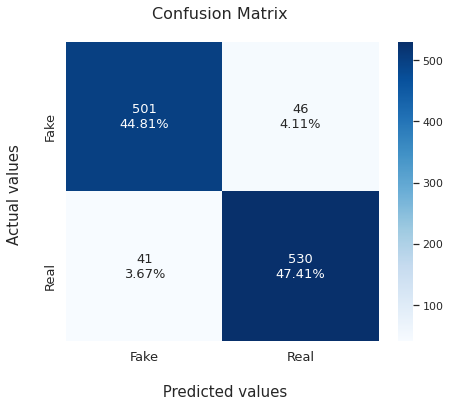

CPU times: user 1 s, sys: 406 ms, total: 1.41 s
Wall time: 398 ms


In [133]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6_no_outliers.csv')
y = df['label']

########### Train, test split ########### 

X = text_vectorized

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### Passive Aggressive CLassifier ########### 

pa_model = PassiveAggressiveClassifier(max_iter = 50)


pa_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = pa_model.predict(X_test)

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
pa_accuracy_score = (pa_model.score(X_test, y_test) * 100)
print('Accuracy: %.2f' % pa_accuracy_score)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)